# Машинное обучение, DS-поток
## Задание 1.11


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.

---

## Генерация текстов с использованием RNN.

**Части задания.** 

* Написание модели, лосса и кода для обучения (7 баллов)

* Реализация жадного алгоритма генерации (3 балла)

* Одно из:

  * Реализация Top k sampling (2 балла)

  * Реализация Beam-search (6 баллов)


В данном задании вы будете генерировать тексты на основании высказываний [Ницше](https://ru.wikipedia.org/wiki/Ницше,_Фридрих) при помощи рекуррентных сетей. 
Модель будет основываться на токенах — словах или более продвинутых способах работы с текстом.



In [ ]:
import io
import os
import sys
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import time
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Скачиваем данные. Корпус состоит из высказываний Ницше, разделеных переносом строки.

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QefWGfvcn0CXzmd42ySFTkwd1shHTUA3'

--2022-04-22 21:13:10--  https://docs.google.com/uc?export=download&id=1QefWGfvcn0CXzmd42ySFTkwd1shHTUA3
Resolving docs.google.com (docs.google.com)... 173.194.193.101, 173.194.193.100, 173.194.193.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.193.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/25sl2mghkp2va7sqatqf9c6e7u6h76f4/1650661950000/14359032242157329066/*/1QefWGfvcn0CXzmd42ySFTkwd1shHTUA3?e=download [following]
--2022-04-22 21:13:11--  https://doc-04-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/25sl2mghkp2va7sqatqf9c6e7u6h76f4/1650661950000/14359032242157329066/*/1QefWGfvcn0CXzmd42ySFTkwd1shHTUA3?e=download
Resolving doc-04-4c-docs.googleusercontent.com (doc-04-4c-docs.googleusercontent.com)... 173.194.195.132, 2607:f8b0:4001:c11::84
Connecting to doc-04-4c-docs.googleusercontent.com (doc-04-4c-docs

In [ ]:
!head nietzsche.txt

PREFACE


SUPPOSING that Truth is a woman--what then? Is there not ground
for suspecting that all philosophers, in so far as they have been
dogmatists, have failed to understand women--that the terrible
seriousness and clumsy importunity with which they have usually paid
their addresses to Truth, have been unskilled and unseemly methods for
winning a woman? Certainly she has never allowed herself to be won; and
at present every kind of dogma stands with sad and discouraged mien--IF,


Посмотрим сколько уникальных слов есть в корпусе.
Также поставим каждому слову (токену) в соответствие число, чтобы далее работать с числами.

In [ ]:
with io.open('./nietzsche.txt', encoding='utf-8') as f:
    text = f.read().lower()

tokenizer = TweetTokenizer()
tokens = list(set(tokenizer.tokenize(text)))
print('total tokens:', len(tokens))

token_indices = {c: i for i, c in enumerate(tokens)}
indices_token = {i: c for i, c in enumerate(tokens)}

total tokens: 11393


11393 уникальных слов — это относительно много, так как придется на каждом шаге решать задачу классификации на 11393 класса. А брать софтмакс от вектора такой большой размерности затруднительно. Поэтому имеется несколько вариантов: простой (1), очень простой (2) и современный (3) .

1. Отбросить редко встречающиеся слова (токены) и заменить их все на токен \<UNK\>. 

2. Использовать в качестве токенов символы, а не слова. Такую модель мы использовали на семинаре для генерации имён.
Этот подход имеет явный недостаток — модели, обучаемой на отдельных символах, гораздо сложнее выучить соотношения между буквами в каждом отдельном слове. Из-за этого может возникнуть ситуация, при которой значительная часть слов, сгенерированных моделью, не будут являться словами языка, на котором написаны входные тексты.

3. Использовать [Byte Pair Encoding](https://arxiv.org/pdf/1508.07909.pdf). [Одна из опен-сорсных реализаций](https://github.com/VKCOM/YouTokenToMe) от ребят из VK.

Существуют также подходы для аппроксимации softmax, такие как иерархический софтмакс и negative sampling.

Разберём, как работает BPE на примере строки `aaabdaaabac`.
Пара `aa` встречается чаще всего, поэтому она будет заменяется символом `Z`, который не используется в данных, получается строка `ZabdZabac`.
Далее процесс повторяется для пары `ab`, которая заменяется на символ `Y`. Теперь строка имеет вид `ZYdZYac`, причем единственная оставшаяся пара исходных символов встречается только один раз. На этом кодировку можно остановить или же продолжать рекурсивно заменив `ZY` на `X`: `XdXac`. Полученную строку нельзя продолжать сжимать, поскольку не существует пары символов, встречающихся более одного раза. Для декодирования нужно выполнить замены в обратном порядке.

Если же мы будем проделывать эту процедуру не над маленькой строкой, а над большим датасетом, то мы найдем часто встречающиеся n-gram-ы из символов в датасете. Полученные замены будем использовать как новые токены и представлять каждое слово как последовательность таких токенов.
В данном случае получится, что частые слова скорей всего будут представлены лишь одним токеном, равным самому слову. А редкие слова разобъются на последовательность токенов, являющихся частыми.


![](https://docs.google.com/uc?export=download&id=1bD-VA4EWfmMsqFT4ufIhCMDh2fKlP_rC)

Метод BPE является некоторой золотой серединой между character-based и word-based подходами.
[`YouTokenToMe`](https://github.com/VKCOM/YouTokenToMe) — одна из опен-сорсных реализаций от разработчиков из VK. 
Также можно посмотреть [статью](https://arxiv.org/abs/1910.13267) студента ФИВТа с конференции ACL 2020 по bpe-dropout.

Ставим библиотеку, речь о которой шла выше:

In [ ]:
! pip install youtokentome

     |████████████████████████████████| 1.7 MB 5.2 MB/s 


Создаем BPE-модель, которую обучим на наших токенах

In [ ]:
import youtokentome as yttm

# Зададим желаемый размер словаря после BPE.
# BPE перестанет объединять символы и токены в тот момент, 
# когда текущее количество токенов >= vocab_size
vocab_size = 1000

def get_bpe(tokens, vocab_size=vocab_size):
    """ 
    Возвращает токенизатор BPE, обученный на токенах.
    Параметры.
    1) tokens - токены,
    2) vocab_size - количество уникальных токенов в итоговом словаре.
    """

    with open('tmp.json', 'w') as file_:
        for token in tokens:
            print(token, file=file_)

    yttm.BPE.train('tmp.json', vocab_size=vocab_size, model="bpe.model")
    os.remove('tmp.json')

    return yttm.BPE(model="bpe.model")


In [ ]:
bpe = get_bpe(tokens)

Пример работы:

In [ ]:
example = text.split('\n')[3]

print('Original: ', example, '\n')
print('BPE decoded: ', *bpe.encode(
    example, output_type=yttm.OutputType.SUBWORD, bos=True, eos=True
    ), '\n', sep=' ')
print('BPE encoded: ', bpe.encode(
    example, output_type=yttm.OutputType.ID, bos=True, eos=True
    ))

Original:  supposing that truth is a woman--what then? is there not ground 

BPE decoded:  <BOS> ▁sup pos ing ▁th at ▁truth ▁is ▁a ▁w oman --what ▁th en ? ▁is ▁there ▁not ▁gr ound <EOS> 

BPE encoded:  [2, 597, 268, 69, 153, 79, 871, 772, 86, 101, 595, 712, 153, 64, 55, 772, 612, 763, 228, 267, 3]


Напишите нейронную сеть, использующую RNN, которая должна обучиться на *каждом шаге* предсказывать следующий токен. Для этого вам понадобится к каждому скрытому состоянию RNN применить некоторую классификационную нейронную сеть. На каждом этапе времени такая сеть будет пытаться предсказать следующий токен. На каждом этапе времени должно получиться свое предсказание вероятности для следующего токена. После этого необходимо усреднить лосс по полученным предсказаниям.

**Замечания** <br>
1). Проследите, что вы действительно предсказываете следующий символ, а не текущий. Для этого можно поступить следующим образом.

Пусть на вход приходит последовательность $x_1, x_2, ..., x_{n}$. Требуется на каждом этапе времени $t$ по символам $x_1, ..., x_{t - 1}$ предсказывать символ $x_t$. Для этого на вход нужно подать последовательность \<BOS\>, $x_1, x_2..., x_{n}$ и в качестве таргетов взять последовательность $x_1, x_2, ..., x_{n}, $ \<EOS\>. В данном случае \<BOS\> (begin of sentence), \<EOS\>(end of sentence) — специальные символы начала и конца предложения (любые новые символы, которых нет в словаре). 

2). При обучении вы подаете на вход истинные токены и предсказываете следующий токен, но при тестировании истинных токенов нет. Поэтому при тестировании стоит поступить следующим образом.
* Подать на вход \<BOS\>, применить рекуррентную ячейку и предсказать вероятности быть следующим символом для каждого токена из словаря. 
* Найти токен с максимальной вероятностью. Обозначим его $x_1$. 
* Подать символ $x_1$ на вход рекуррентной ячейке и предсказать вероятности для следующих символов. 
* И так далее. Генерация продолжается до тех пор, пока не был предсказан токен \<EOS\> или мы не достигли нужной `length_to_predict` длины сгенерированного текста, где `length_to_predict` — число, заданное заранее.

Заметим, что при наличии начальной последовательности $x_1, .., x_k$, которую нужно продолжить, сначала на вход нужно подавать истинные символы, а затем, когда истинные закончатся, подавать предсказанные символы. То есть в этом случае мы подаем \<BOS\>, $x_1, .., x_k$ на вход и уже потом начинаем генерацию.

На рисунке ниже можно увидеть пример такой сети. При обучении на вход подаются истинные токены. На этапе времени $t - 1$ предсказываются вероятности $\widehat{y}_{i}$ быть следующим ($i$-ым) токеном для всех токенов из словаря. 
В качестве лосса в данном случае рассматривается функция $\frac{1}{n} \sum\limits_{i=1}^{n} H(y_i, \widehat{y}_i)$, где $H(\mathsf{P}, \mathsf{Q})$ — кросс-энтропия, а $y^i$ — вырожденное распределение, соответствующее истинному индексу $i$-ого токена.

На этапе применения на вход рекуррентной ячейке подается не настоящий токен, а тот токен, который имел наибольшую вероятность быть следующим на предыдущем шаге.

![img](https://i.ibb.co/BnftCLh/Screenshot-2019-05-03-at-21-45-01.png)

![imh](https://i.ibb.co/rwHyYsK/Screenshot-2019-05-03-at-21-44-53.png)

Получим таргеты для обучения. Для этого к каждой строке, т.е. последовательности bpe-токенов добавим токен '\<EOS\>'. Также, сделаем так, чтобы все строки были одной и той же длины, добавив паддинг из символов '\<PAD\>'.

Таким образом, строка $x_1, x_2, ..., x_{8}$ должна преобразиться в $x_1, x_2, ..., x_{8}$, \<EOS\>, \<PAD\>, \<PAD\>, \<PAD\> в случае если мы хотим, чтобы длина всех строк была 12.

После данных преобразований переведите полученные строки в последовательность чисел, с которыми уже далее будет работать модель. Для этого можно использовать метод `bpe.subword_to_id`

Для этого сначала найдем максимальную длину строки.

In [ ]:
length = []

for string in text.split('\n'):
    bpe_string = bpe.encode(string, output_type=yttm.OutputType.SUBWORD, bos=False, eos=False)
    if len(bpe_string) > 0:
      length.append(len(bpe_string))
print("Максимальная длина строки:", np.max(length))

Максимальная длина строки: 40


Посчитаем таргеты. Учитывайте, что так как мы добавляем символ \<EOS\>, то полученная длина строки должна быть на 1 больше.

*Замечание* 

После разбиения текста `text` на строки стоит проверить, что все строки имеют ненулевую длину. Строки нулевой длины нужно выкинуть.

In [ ]:
MAX_LENGTH = np.max(length) + 1
target = []

for string in text.split('\n'):
    bpe_string = bpe.encode(string, output_type=yttm.OutputType.ID, bos=False, eos=True)
    if len(bpe_string) > 1:
      bpe_string+=[bpe.subword_to_id('<PAD>')]*(MAX_LENGTH-len(bpe_string))
      target.append(bpe_string)
target=np.array(target)
target.shape

(9037, 41)

Получим то, что подается на вход нейросети. Из таргет-строк получите строки тех же длин, которые начинаются с символа \<BOS\> и будут без последнего символа таргет-строки. Полученные строки также должны состоять из чисел, как и ранее посчитанные таргет-строки.

In [ ]:
target_input=target.copy()
target_input=np.roll(target_input, 1, axis=1)
target_input[:,0]=bpe.subword_to_id('<BOS>')
index_EOS=np.where(target_input==bpe.subword_to_id('<EOS>'))
target_input[index_EOS]=bpe.subword_to_id('<PAD>')

In [ ]:
pad_idx=bpe.subword_to_id('<PAD>')
num_tokens=vocab_size

Разбейте полученные данные на обучение и валидацию.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(target_input, target, test_size=0.2, random_state=5)

Приступим к написанию модели. Ваша модель должна состоять из эмбеддинг слоя, рекуррентного слоя (по желанию, возможно несколько слоев) и линейного слоя, который будет применяться к каждому скрытому состоянию рекуррентного слоя.

В качестве рекуррентного слоя (слоев) лучше использовать `nn.GRU`, `nn.GRUCell`, `nn.LSTM` или `nn.LSTMCell` по вашему желанию.

In [ ]:
class Model(nn.Module):
  #сделаем модель на основе nn.GRU, должно дать более хороший результат
  #так как у нас не так много данных
  def __init__(self, num_tokens=num_tokens, emb_size=1000, hidden_size =500):
    super(Model, self).__init__()
    self.emb = nn.Embedding(vocab_size, emb_size)
    self.gru = nn.GRU(emb_size, hidden_size , batch_first=True, dropout=0.1)
    self.hid_to_logits = nn.Linear(hidden_size , num_tokens)

  def forward(self, x,h0=None):
    emb = self.emb(x)
    
    if h0 is not None:
      output, h = self.gru(emb,h0)
    else:
      output, h = self.gru(emb)

    next_logits = self.hid_to_logits(output)

    # next_logits.size = [batch_size, max_name_len, num_tokens]
    next_logp = F.log_softmax(next_logits, dim=-1)
    return next_logp,h


Напишите функцию вычисления лосса. 

**Замечание.**

Добавленные при помощи паддинга символы не должны оказывать влияния на лосс. То есть по позициям, где истинный символ является специальным символом для паддинга, при вычислении лосса не нужно обращать внимания на предсказания. В противном случае нейронная сеть может научиться всегда предсказывать этот специальный символ из-за того, что он часто встречается. 

Однако, лосс по символу '\<EOS\>' должен быть посчитан и добавлен к финальному лоссу.

Например, можно посчитать лосс следующим образом:

`criterion = nn.CrossEntropyLoss(ignore_index=pad_ix, size_average=True)`

`criterion(logits, y_batch)`

вместо

`F.cross_entropy(logits, y_batch)`

Здесь `pad_ix` — число, которое мы поставили в соответствие специальному символу для паддинга ранее.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def compute_loss(model, X_batch, y_batch):
    criterion = nn.NLLLoss(ignore_index=pad_idx, size_average=True)
    X_batch = torch.tensor(X_batch, dtype=torch.int64).to(device)
    y_batch = torch.tensor(y_batch, dtype=torch.int64).to(device)
    
    # Логиты, полученные моделью
    logits,_= model(X_batch)
    #print(logits.shape,logits.contiguous().view(-1, num_tokens).shape,y_batch.shape)
    # Лосс на валидации
    loss = criterion(logits.contiguous().view(-1, num_tokens),
                 y_batch.long().contiguous().view(-1))
    return loss

In [ ]:
def compute_accuracy(model, X_batch, y_batch):
    X_batch = torch.tensor(X_batch, dtype=torch.int64).to(device)
    
    # Логиты, полученные моделью
    logits,_ = model(X_batch)
    logits=np.argmax(logits.cpu().detach().numpy(),axis=2)
    
    acc=accuracy_score(y_batch.reshape(-1),logits.reshape(-1))
    return acc

Напишем функцию генерации батчей.

In [ ]:
def iterate_minibatches(X, y, batch_size, shuffle=True):
    """ Генератор случайных батчей """

    if shuffle:
        indices = np.random.permutation(np.arange(len(X)))
    else:
        indices = np.arange(len(X))
        
    for start in range(0, len(indices), batch_size):
        ix = indices[start: start + batch_size]
        yield X[ix], y[ix]

Инициализируем модель.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Обучение. Это может занять некоторое время. Постройте также график кривой обучения.

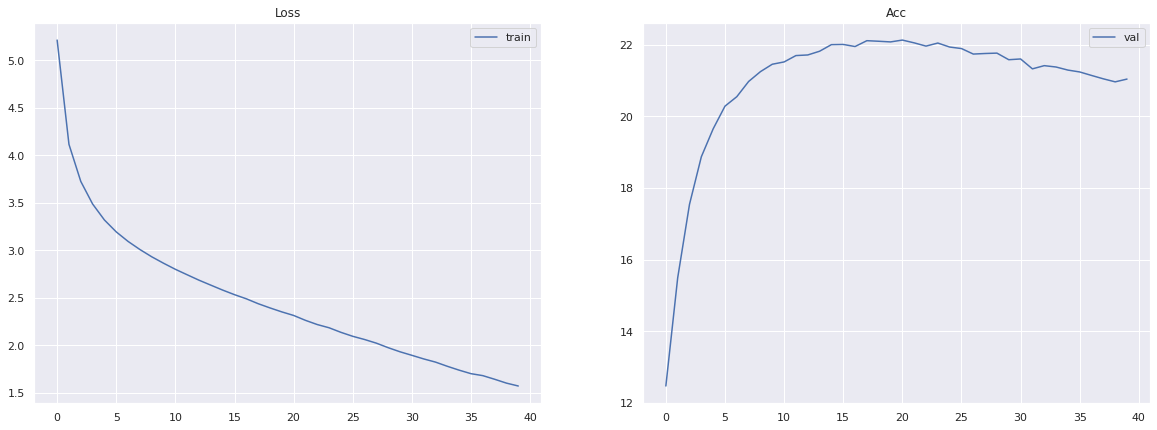

Epoch 40 of 40 took 5.165s
  training loss (in-iteration): 	1.571384
  validation accuracy: 			21.04 %
CPU times: user 3min 24s, sys: 1.96 s, total: 3min 26s
Wall time: 3min 27s


In [ ]:
%%time
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

train_loss = []
val_accuracy = []
num_epochs = 40 
batch_size = 64  

train_loss_epoch=[]
val_accuracy_epoch=[]
best_val_acc=0

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Обучение
    model.train(True)
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size, True):
        loss=compute_loss(model,X_batch, y_batch)

        # делаем backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss.append(loss.detach().cpu().numpy())

    # Валидация
    model.train(False)
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size, False):
        acc=compute_accuracy(model,X_batch, y_batch)
        val_accuracy.append(acc)

    train_loss_epoch.append(np.mean(train_loss[-len(X_train) // batch_size :]))
    val_acc=np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100
    val_accuracy_epoch.append(val_acc)
    if best_val_acc<val_acc:
            best_val_acc=val_acc
            torch.save(model, 'gru_model')

    clear_output(True)
    fig = plt.figure(figsize=(20, 7))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss_epoch, label='train')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(val_accuracy_epoch, label='val')
    plt.title('Acc')
    plt.legend()
    plt.show()


    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

    

Не прекрасный результат с точки зрения acc, также видно, что с эпохи 20 модель начала переобучаться, но при этом для простой нейронки очень достойный результат получили

Напишите функцию, которая по началу высказывания будет генерировать следующие `length_to_predict` символов:
* Входной текст приведите к формату, который принимает на вход модель. 
* Предскажите первый символ. 
* Предсказаный символ следует добавить в конец текста и полученный текст опять привести к нужному формату. Альтернативно, вы можете прогнать лишь одну ячейку рекуррентной сети, на вход которой подать только что предсказанный символ и в качестве предыдущего скрытого состояния которой взять скрытое состояние полученное на предыдущем шаге.
* Затем можно предсказать следующий символ и так далее. 


*Замечания.*

1. Модель принимает объекты батчами, поэтому если вы будете подавать ей один элемент она может ругаться. Один элемент нужно подавать как батч размера 1.

2. Для получения предсказания в виде индекса следующего символа нужно найти аргмаксимум по логитам. В этом вам поможет `logits.max(dim)`, который принимает в аргументах размерность `dim` по которой искать максимумы и возвращает сразу 2 тензора — максимумы и индексы максимумов.




Сначала реализуйте жадную генерации текста — на каждом шаге берите токен с наибольшей вероятностью.

In [ ]:
def simple_predict(model, text, length_to_predict):
    #важно не забыть про MAX_LENGTH
    bpe_string = bpe.encode(text, output_type=yttm.OutputType.ID, bos=True, eos=False)
    start=bpe_string.copy()

    len_pad=(MAX_LENGTH-len(bpe_string))
    if MAX_LENGTH>len(bpe_string):
        bpe_string+=[bpe.subword_to_id('<PAD>')]*(MAX_LENGTH-len(bpe_string))

    bpe_string=np.array(bpe_string)
    res=[]
    log_probs=[]
    for i in range(length_to_predict):
        #print(bpe_string)
        model.train(False)
        X_batch=[bpe_string]
        X_batch = torch.tensor(X_batch, dtype=torch.int64)
        # Логиты, полученные моделью
        logp_next,_ = model(X_batch)
        p_next = F.softmax(logp_next / 1, dim=-1).data.numpy()[0, -len_pad-1]
        index_next=np.argmax(p_next)
        res.append(index_next)
        log_probs.append(np.max(p_next))
        if index_next==bpe.subword_to_id('<EOS>'):
            break
        
        if len_pad>0:
            index_first_pad=np.where(bpe_string==pad_idx)[0][0]
            bpe_string[index_first_pad]=index_next
            len_pad-=1
        else:
            bpe_string=np.roll(bpe_string, -1)
            bpe_string[-1]=index_next

    return start+res,log_probs

    


Посмотрим, что предсказывает модель. Не пугайтесь, если будет не много смысла в самих высказываниях.

In [ ]:
model = torch.load('/content/gru_model')
model.train(False)
device = torch.device('cpu')
model = model.to(device)

In [ ]:
text, log_probs = simple_predict(model, "be no mistake about it:", 50)

bpe.decode([(text)])

['<BOS> be no mistake about it: "what is to say, in the same time the<EOS>']

In [ ]:
text, log_probs = simple_predict(model, "artificial intelegence is interesting", 50)

bpe.decode([(text)])

['<BOS> artificial intelegence is interesting to their own sake, and that they<EOS>']

In [ ]:
text, log_probs = simple_predict(model, 'people love ml and', 30)

bpe.decode([(text)])

['<BOS> people love ml and the most spiritual fate of authority of the<EOS>']

In [ ]:
!head nietzsche.txt

PREFACE


SUPPOSING that Truth is a woman--what then? Is there not ground
for suspecting that all philosophers, in so far as they have been
dogmatists, have failed to understand women--that the terrible
seriousness and clumsy importunity with which they have usually paid
their addresses to Truth, have been unskilled and unseemly methods for
winning a woman? Certainly she has never allowed herself to be won; and
at present every kind of dogma stands with sad and discouraged mien--IF,


На самом деле с генерацией довольно много нюансов происходит, а именно: 1) есть несколько способом генерации предложений, мы можем давать предложение и каждый раз давать модели все более длинное и длинное предложение, или мы можем давать по одному слову. В данном случае 1 вариант более предпочительный в отличии от задачи генерации имен на семинаре, так как тут мы работает с батчами+мы не делаем np.random.choice. 
2) Изначально у меня были проблемы с зацикливанием, но улучшив метрику модели я смог отчасти избавиться от данной проблемы, но зато у меня появилась новая, а именно "любовь ставить EOS". На самом деле это проблема появляется из-за формата данных, которые поступают нам, давайте внимательно посмотрим, становится понятно, что нам поступают строчки, а не предложения. То есть мы учимся на тексте, где оч часто встречается незаконченная мысль (именно этот результат видим после генерации текста).
3)**Сам вывод** на самом деле текст получился довольно хорошим и даже слегка логичным по тексту, видно, что вставлялись не рандомные токены. 
a)be no mistake about it: "what is to say, in the same time the
не заблуждайтесь на этот счет: "что сказать, в то же время

b)artificial intelegence is interesting to their own sake, and that they
искусственный интеллект интересен сам по себе, и что они

c)people love ml and the most spiritual fate of authority of the
люди любят мл и самую духовную судьбу власти в

Но при этом все равно очевидна нам неидеальность и довольно среднее качество данных результатов, модель можно было сделать более сложной, добавить больше слоев, но координальным решением наших проблем было бы использование Transformer

Жадная генерация не самая хорошая. Возможно ваши предсказания зациклились. Это связано с тем, что 
1. Модель в основном смотрит лишь на последние несколько токенов при предсказании следующего.

2. При предсказании модель генерирует жадно и максимизирует вероятность только одного следующего токена, не думая про то, что может быть дальше.

3. Модель была обучена максимизировать правдоподобие и генерировать токены смотря лишь на предыдущие токены. Из этого модель сильно теряет в разнообразии и может получится так, что модель найдет некоторые часто повторяющиеся структуры в датасете и будет присваивать им большую вероятность. 

Для решения этой проблемы существует несколько методов. Одни из них:

* Top k sampling 

  Для предсказания следующего токена посмотрим на  распределение вероятностей на следующий токен. Выбираем $k$ токенов с максимальной вероятностью и из них сэмплируем один токен с вероятностью пропорциональной предсказанной для этого токена вероятности.

* Beam-search


\\

**Реализуйте один из подходов.** 

* Top k sampling (1 балл)

* Beam-search (3 балла)

Учитывайте, что реализовать beam-search намного сложнее, чем top k sampling, поэтому за его реализацию дается больше баллов.

In [ ]:
def vector_prob(model,bpe_string,len_pad):
  model.train(False)
  X_batch=[bpe_string]
  X_batch = torch.tensor(X_batch, dtype=torch.int64)
  # Логиты, полученные моделью
  logp_next,_ = model(X_batch)
  p_next = F.softmax(logp_next / 1, dim=-1).data.numpy()[0, -len_pad-1]
  return p_next

In [ ]:
beam = 30


def predict(model, text, length_to_predict):
    bpe_string = bpe.encode(text, output_type=yttm.OutputType.ID, bos=True, eos=False)
    start = bpe_string.copy()

    len_pad = (MAX_LENGTH - len(bpe_string))
    if MAX_LENGTH > len(bpe_string):
        bpe_string += [bpe.subword_to_id('<PAD>')] * (MAX_LENGTH - len(bpe_string))

    bpe_string = np.array(bpe_string)
    tree = {}
    index_tree = set([0])
    tree[0] = [bpe_string, len_pad, 1, False, []]
    # в таком формате мы будем хранить узел, мб было легче структуру Node написать
    # [bre_sting,len_pad, вероятность данной ветви,был ли eos уже,res]
    for i in range(length_to_predict):
        index_tree_list = list(index_tree)
        for j in index_tree_list:
          #перебираем узлы
            array=tree[j].copy()
            bpe_string, len_pad, prob_last, status, res = array
            if status == True:
                continue
            prob = vector_prob(model, bpe_string, len_pad)
            index = np.argsort(prob)[-beam:]
            prob = np.array(prob)[index]

            # теперь нам надо данный узел разветвить
            if len_pad > 0:
                len_pad -= 1
            for k in range(beam):
                bpe_string_copy=bpe_string.copy()

                number = max(index_tree) + 1
                index_tree.add(number)

                index_next = index[k]
                prob_now = prob[k]
                res_local = res.copy()
                res_local.append(index_next)
                if index_next == bpe.subword_to_id('<EOS>'):
                    tree[number] = [bpe_string_copy, len_pad, prob_now * prob_last, True, res_local]
                    continue
                elif len_pad >= 0:
                    index_first_pad = np.where(bpe_string == pad_idx)[0][0]
                    bpe_string_copy[index_first_pad] = index_next
                else:
                    bpe_string_copy = np.roll(bpe_string, -1)
                    bpe_string_copy[-1] = index_next
                tree[number] = [bpe_string_copy, len_pad, prob_now * prob_last, False, res_local]

            index_tree.discard(j)
            tree.pop(j, None)

        # осталось совсем немного
        # очень важная часть кода, а именно удаление неоптимальных ветвей нашего дерева
        index_tree_list = list(index_tree)

        if len(index_tree_list) <= beam:
            continue
        dict_number_prob = {j: tree[j][2] for j in index_tree_list}
      
        sorted_tuples = sorted(tree.items(), key=lambda item: item[1][2], reverse=True)
        sorted_tuples = sorted_tuples[beam:]
        for tuple_now in sorted_tuples:
            index_tree.discard(tuple_now[0])
            tree.pop(tuple_now[0], None)

    # теперь нам выбрать самый вероятный путь и его вывести
    index_tree_list = list(index_tree)
    dict_number_prob = {j: tree[j][2] for j in index_tree_list}
    sorted_tuples = sorted(tree.items(), key=lambda item: item[1][2],reverse=True)
    best_index = sorted_tuples[0][0]
    return start+tree[best_index][4]


In [ ]:
text= predict(model, "be no mistake about it:", 50)

bpe.decode([(text)])

['<BOS> be no mistake about it: "beyond good and evil."<EOS>']

In [ ]:
text= predict(model, "artificial intelegence is interesting", 50)

bpe.decode([(text)])

['<BOS> artificial intelegence is interesting themselves.<EOS>']

In [ ]:
text= predict(model, 'people love ml and', 30)

bpe.decode([(text)])

['<BOS> people love ml and that is to say, that is to say, as the<EOS>']

Получили прекрасный результат, получили уже даже понятный текст по смыслу, особенно прекрасен второй текст artificial intelegence is interesting themselves. искусственный интеллект интересен сам по себе.


people love ml and that is to say, that is to say, as the=люди любят ml, и это означает, что, то есть, как. (слегка незаконченная мысль).


be no mistake about it: "beyond good and evil."=не заблуждайтесь на этот счет: "по ту сторону добра и зла". (филофская мысль, очень подходит под произведение)

Получили намного лучше результат, прям радует глаза логичные тексты, но также есть недостаток, что слегка рано eos, но это так как текст поступает нам по строчкам и в нем часто есть незаконченные предложения, в идеале нам конечно давали бы предложения, которые заканичваются обычным знаком препинания.


### **Дополнительная информация**

[Статья](https://www.aclweb.org/anthology/P19-1365.pdf) с ACL 2019 про сравнение различных методов декодирования.